In [ ]:
# Mount Google Colab

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd '/content/gdrive/My Drive/Masters_Thesis'


Mounted at /content/gdrive
/content/gdrive/My Drive/Masters_Thesis


In [ ]:
!pip install stepmix # library used to build LCA model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from stepmix.stepmix import StepMix

from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

np.random.seed(42)

In [ ]:
# Provide the filename of your Excel file
file_name = 'preprocessed_reduced_pcaCV.xlsx'

# Read the Excel file into a pandas DataFrame
reduced_pcaSC = pd.read_excel(file_name)


In [ ]:
work_values = reduced_pcaSC[reduced_pcaSC['maingroup'] == 'tests.workvalues.title']
len(work_values.question_id.unique())

# Above gives: array(['Prestaties leveren', 'Arbeidsvoorwaarden', 'Erkenning',
#       'Collegialiteit', 'Ondersteuning', 'Onafhankelijkheid'],
#      dtype=object)

#Is the same as:
#array(['Deliver performance', 'Terms of employment', 'Recognition',
#       'Collegiality', 'Support', 'Independence'],
#      dtype=object)

14

#Splitting data into answers for work_values test

In [ ]:
# Specify the column names you want to keep
columns_to_keep = ['question_id', 'maingroup', 'level1subgroup']

# Subset the DataFrame using the specified columns
wrk_v = work_values.loc[:, columns_to_keep]

wrk_v = wrk_v.drop(['maingroup'], axis=1)
qs = wrk_v.drop_duplicates(subset='question_id')
qs = qs.sort_values('level1subgroup')
qs

# Create the 'short_name' column
qs['short_name'] = ''

# same process as outlined in personality test
count_dp = 1
count_toe = 1
count_r2 = 1
count_c2 = 1
count_s2 = 1
count_i2 = 1

for index, row in qs.iterrows():
    if row['level1subgroup'] == 'Prestaties leveren':
        qs.at[index, 'short_name'] = f'drp{count_dp}'
        count_dp += 1

    elif row['level1subgroup'] == 'Arbeidsvoorwaarden':
        qs.at[index, 'short_name'] = f'toe{count_toe}'
        count_toe += 1

    elif row['level1subgroup'] == 'Erkenning':
        qs.at[index, 'short_name'] = f'rec{count_r2}'
        count_r2 += 1

    elif row['level1subgroup'] == 'Collegialiteit':
        qs.at[index, 'short_name'] = f'col{count_c2}'
        count_c2 += 1

    elif row['level1subgroup'] == 'Ondersteuning':
        qs.at[index, 'short_name'] = f'sup{count_s2}'
        count_s2 += 1
    else:
        qs.at[index, 'short_name'] = f'ind{count_i2}'
        count_i2 += 1
qs

,question_id,level1subgroup,short_name
60,2336,Arbeidsvoorwaarden,toe1
61,2344,Arbeidsvoorwaarden,toe2
62,2337,Arbeidsvoorwaarden,toe3
65,2349,Collegialiteit,col1
66,2338,Collegialiteit,col2
63,2339,Erkenning,rec1
64,2342,Erkenning,rec2
70,2343,Onafhankelijkheid,ind1
71,2340,Onafhankelijkheid,ind2
72,2341,Onafhankelijkheid,ind3


In [ ]:
n_qs = qs.drop(['level1subgroup'], axis=1)

# merging (left join) studeies to orginal dataframe
new_qs = pd.merge(work_values, n_qs, on='question_id', how='left')
new_qs.head(3)

,question_id,dossier_id,answeredTest_id,question,type,label,datetime,maingroup,maingroup_id,faculty,level1subgroup,level1subgroup_id,answer,short_name
0,2347,1532,13164,question.id_2347,likert/likert5puntsacceptatie2positief,Dat ik kan doen waar ik goed in ben,2021-09-15 13:48:23,tests.workvalues.title,508,Faculteit Betawetenschappen,Prestaties leveren,509,0.4,drp1
1,2336,1532,13164,question.id_2336,likert/likert5puntsacceptatie2positief,Dat ik de hele dag bezig kan zijn,2021-09-15 13:48:24,tests.workvalues.title,508,Faculteit Betawetenschappen,Arbeidsvoorwaarden,510,0.2,toe1
2,2344,1532,13164,question.id_2344,likert/likert5puntsacceptatie2positief,Dat ik alléén kan werken,2021-09-15 13:48:24,tests.workvalues.title,508,Faculteit Betawetenschappen,Arbeidsvoorwaarden,510,0.0,toe2


In [ ]:
qs_data = pd.pivot_table(new_qs, values='answer', index='dossier_id', columns='short_name')

# Reset index
qs_data = qs_data.reset_index()
qs_data = qs_data.rename_axis(None, axis=1)
# Remove NAN values
qs_data.replace('', np.nan, inplace=True)
qs_data = qs_data.dropna()
qs_data

,dossier_id,col1,col2,drp1,ind1,ind2,ind3,rec1,rec2,sup1,sup2,sup3,toe1,toe2,toe3
0,1532,0.8,0.6,0.4,0.4,0.4,0.0,0.2,0.4,0.6,0.6,0.8,0.2,0.0,0.0
1,2112,0.2,0.8,0.8,0.6,0.8,0.4,0.4,0.8,0.0,0.4,0.4,0.0,0.0,0.2
2,30690,0.4,0.6,0.8,0.6,0.8,0.6,0.8,0.6,0.8,0.8,0.6,0.8,0.4,0.6
3,42388,0.6,0.0,0.6,0.8,0.8,0.8,0.2,0.6,0.4,0.4,0.4,0.2,0.0,0.2
4,42415,0.4,0.0,0.8,0.6,0.8,0.4,0.6,0.4,0.8,0.6,0.0,0.0,0.2,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,91894,0.4,0.8,0.4,0.6,0.6,0.6,0.6,0.6,0.8,0.6,0.6,0.2,0.4,0.4
445,91908,0.6,0.8,0.8,0.6,0.6,0.4,0.0,0.6,0.6,0.8,0.4,0.8,0.0,0.6
446,91927,0.8,0.6,0.8,0.6,0.6,0.4,0.2,0.6,0.6,0.4,0.4,0.4,0.4,0.4
447,91928,0.4,0.6,0.8,0.8,0.6,0.8,0.4,0.6,0.6,0.6,0.6,0.6,0.6,0.8


No need to sort the columns

In [ ]:
model = qs_data.drop('dossier_id', axis=1)
model

# Collect data for LCA before possible K-Means manipulation
data_lca = model

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Creating X variable to use as to not effect the model data
X = model

# Range of cluster numbers to test
n_clusters_range = range(2, 10)

# Initialize dictionaries to store the metrics
metrics = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': [],
    'n_clusters': []
}

# Loop over the cluster numbers and perform clustering
for i, n_clusters in enumerate(n_clusters_range):

    # Run hierarchical clustering using the ward linkage method
    ward_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    ward_cluster.fit(X)

    #Extract the labels and linkage matrix
    ward_labels = ward_cluster.labels_
    linkage_matrix = ward_cluster.children_

    # Extract the cluster centroids from the linkage matrix
    centroids = []
    for j in range(n_clusters):
        indices = ward_labels == j
        centroid = X[indices].mean(axis=0)
        centroids.append(centroid)
    kmeans_cluster = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=0)
    kmeans_cluster.fit(X)
    cluster_labels = kmeans_cluster.labels_

    # Calculate the metrics for the current cluster assignment
    inertia = kmeans_cluster.inertia_
    silhouette = silhouette_score(X, kmeans_cluster.labels_)
    calinski_harabasz = calinski_harabasz_score(X, kmeans_cluster.labels_)
    davies_bouldin = davies_bouldin_score(X, kmeans_cluster.labels_)

    # Store the metrics in the dictionary
    metrics['silhouette'].append(silhouette)
    metrics['calinski_harabasz'].append(calinski_harabasz)
    metrics['davies_bouldin'].append(davies_bouldin)
    metrics['n_clusters'].append(n_clusters)

# Convert the metrics dictionary to a Pandas dataframe
metrics_df = pd.DataFrame(metrics)

metrics_df

,silhouette,calinski_harabasz,davies_bouldin,n_clusters
0,0.224037,117.177496,1.885223,2
1,0.133933,77.992372,2.244588,3
2,0.102690,62.924498,2.143035,4
3,0.093604,54.464318,2.407765,5
4,0.089371,49.290542,2.357643,6
5,0.081615,44.009530,2.292496,7
6,0.089349,42.544738,2.198053,8
7,0.089899,39.710859,2.163895,9


<Axes: xlabel='PC1', ylabel='PC2'>

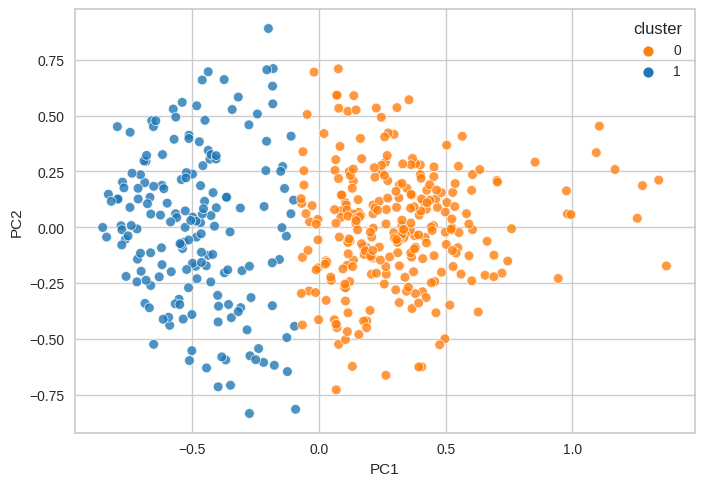

In [ ]:
# Creating K-means Cluster Model
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA

seed = 1234 # Used for reproducibility

kmeans = KMeans(n_clusters=2, n_init = 10, random_state=seed)
k_fit = kmeans.fit(model)
centroids = kmeans.cluster_centers_
predictions = k_fit.labels_

# Develop 2 PCA components for visualizations
pca = PCA(2)
pca_data = pd.DataFrame(pca.fit_transform(model),columns=['PC1','PC2'])

# To maintain cluster colours to allow for easier comparison between cluster plots
color_dict = dict({0: sns.color_palette("tab10")[1], 1: sns.color_palette("tab10")[0]})

pca_data['cluster'] = pd.Categorical(predictions)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data, palette=color_dict, alpha=0.8)

In [ ]:
#pca_data.to_excel('pcaCV_work_v_clusters.xlsx', index=False)# to be used for comparison in personality notebook

#Latent Class Analysis

In [ ]:
from sklearn.model_selection import ParameterGrid

# Create LCA model
model = StepMix(n_components=3, measurement="categorical", verbose=1, random_state=123, n_init=10)

grid = {
    'n_components': [2, 3, 4, 5, 6, 7, 8, 9],
    'n_steps' : [1]
}

results = dict(param_n_steps=[], param_n_components=[], aic=[], bic=[])


# Same model and grid as above
for g in ParameterGrid(grid):
    model.set_params(**g)
    model.fit(data_lca)
    results['param_n_steps'].append(g['n_steps'])
    results['param_n_components'].append(g['n_components'])
    results['aic'].append(model.aic(data_lca))
    results['bic'].append(model.bic(data_lca))

# Save results to a dataframe
results = pd.DataFrame(results)

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 37.46it/s, max_LL=-124, max_avg_LL=-.277]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 14 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000]
        Class 2 : [0.6003 0.3997 0.5004 0.4996 0.4004 0.5996 0.9001 0.0999 0.6003 0.3997
 0.7002 0.2998 1.0000 0.0000 0.4004 0.5996 0.4004 0.5996 0.5004 0.4996
 0.4004 0.5996 0.7002 0.2998 1.0000 0.0000 0.7002 0.2998]
    Class weights
        Class 1 : 0.98
        Class 2 : 0.02
    Fit for 2 latent classes
    Estimation method             : 1-step
    Numbe

Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 42.97it/s, max_LL=-124, max_avg_LL=-.277]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 14 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.6003 0.3997 0.5004 0.4996 0.4004 0.5996 0.9001 0.0999 0.6003 0.3997
 0.7002 0.2998 1.0000 0.0000 0.4004 0.5996 0.4004 0.5996 0.5004 0.4996
 0.4004 0.5996 0.7002 0.2998 1.0000 0.0000 0.7002 0.2998]
        Class 2 : [1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000]
        Class 3 : [1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000

Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 48.98it/s, max_LL=-124, max_avg_LL=-.277]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 14 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000]
        Class 2 : [1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000]
        Class 3 : [1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000

Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 52.08it/s, max_LL=-124, max_avg_LL=-.277]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 14 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000]
        Class 2 : [1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000]
        Class 3 : [1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000

Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 45.46it/s, max_LL=-118, max_avg_LL=-.264]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 14 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.5557 0.4443 0.4446 0.5554 0.3335 0.6665 0.8889 0.1111 0.6667 0.3333
 0.6668 0.3332 1.0000 0.0000 0.3335 0.6665 0.3335 0.6665 0.4446 0.5554
 0.3335 0.6665 0.7778 0.2222 1.0000 0.0000 0.6668 0.3332]
        Class 2 : [1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000]
        Class 3 : [1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000

Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 43.00it/s, max_LL=-118, max_avg_LL=-.264]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 14 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000]
        Class 2 : [1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000]
        Class 3 : [1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000

Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 48.50it/s, max_LL=-109, max_avg_LL=-.245]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 14 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [0.6665 0.3335 0.6665 0.3335 1.0000 0.0000 0.6665 0.3335 0.0000 1.0000
 0.3331 0.6669 1.0000 0.0000 0.3331 0.6669 0.6665 0.3335 1.0000 0.0000
 1.0000 0.0000 0.3335 0.6665 1.0000 0.0000 0.3331 0.6669]
        Class 2 : [1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000]
        Class 3 : [1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000

Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 38.93it/s, max_LL=-118, max_avg_LL=-.264]

MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 14 features, each with up to 2 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 2 are associated with the first feature,
        columns 3 to 4 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000]
        Class 2 : [1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000]
        Class 3 : [1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000
 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000

In [ ]:
results[['param_n_components', 'aic', 'bic']].round().astype(int) # print LCA results

,param_n_components,aic,bic
0,2,301,412
1,3,329,497
2,4,357,583
3,5,385,668
4,6,401,742
5,7,429,827
6,8,440,896
7,9,485,998
